<a href="https://colab.research.google.com/github/Mario1159/sscs-ose-chipathon.github.io/blob/main/initial_notebooks_2023/submitted_notebooks/labbench-on-chip-sar-adc/SAR_ADC_proposal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12-bit SAR ADC design for a lab-bench-on-chip

```
AC3E-UTFSM-ITU-INL Team, May 2023
SPDX-License-Identifier: Apache-2.0
```


|Name|Email|Affiliation|IEEE Member|SSCS Member|
|:--:|:--:|:----------:|:----------:|:----------:|
|Alonso Rodríguez|alonso.rodb@gmail.com|AC3E|No|No|
|Kevin Pizarro|kevin.pizarroa@sansano.usm.cl|Universidad Técnica Federico Santa María|Yes|Yes|
|Vicente Osorio|vicente.osorio@usm.cl|Universidad Técnica Federico Santa María|Yes|Yes|
|Andrea Núñez|anunezd@usm.cl|Universidad Técnica Federico Santa María|No|No|
|Mario Romero|mario.romeron@usm.cl|Universidad Técnica Federico Santa María|Yes|Yes|
|Felipe Torres|felipe.torreso@sansano.usm.cl|Universidad Técnica Federico Santa María|Yes|Yes|
|Patricio Carrasco|patricio.carrascoo@sansano.usm.cl|Universidad Técnica Federico Santa María|Yes|Yes|
|Sebastián Sánchez|sebastian.sanchezp@usm.cl|Universidad Técnica Federico Santa María|Yes|Yes|
|Jesús Ávila|jesus.avila.05@gmail.com|Universidad Nacional de Tucumán|No| No|
|Martín Muñoz|martin.munozmun@usm.cl|Universidad Técnica Federico Santa María|No|No|
|Valeria Muñoz|valeria.munoz@usm.cl|Universidad Técnica Federico Santa María|No|No|
|Joaquín Saldías|joaquin.saldiasa@usm.cl|Universidad Técnica Federico Santa María|No|No|
|Felipe Rifo|felipe.rifo@sansano.usm.cl|Universidad Técnica Federico Santa María|No|No|
|Alper Kurt (Advisor)|alper.kurt@tera-micro.com|Istanbul Technical University|No|No
|Accel Abarca (Advisor)|abarca.prouza@gmail.com|INL - International Iberian Nanotechnology Laboratory|No|No|
|Jorge Marín (Lead) <br />|jorge.marinn@usm.cl|AC3E|Yes|Yes|
|Christian Rojas (Advisor)|c.a.rojas@ieee.org|AC3E, Universidad Técnica Federico Santa María|Yes|No|

**_Abstract_** - This notebook introduces our proposal for the SSCS PICO Open-Source Chipathon. We aim to design a 12-bit Successive Approximation Register (SAR) Analog-to-Digital Converter (ADC) for the measurement channel of an integrated oscilloscope, targeting the open-source GlobalFoundries GF180MCU PDK. Our team researched various topologies for the different blocks of the SAR ADC and conducted simulations for the chosen design. We expect our design to achieve a sampling rate greater than or equal to 1.5 Msps and an ENOB greater than or equal to 9 bits.

**_Keywords_** - ADC; Succesive approximation register (SAR); Charge redistribution; lab-bench-on-chip; oscilloscope channel.

## Tool Installation

The tools to be used and therefore installed are ngspice and Icarus verilog.

In [ ]:
#@title Install dependencies {display-mode: "form"}
#@markdown - Click the ▷ button to setup the digital design environment based on [conda-eda](https://github.com/hdl/conda-eda).

ngspice_version = 'latest' #@param {type:"string"}
gf180mcu_fd_pr_version = 'latest' #@param {type:"string"}
sky130_fd_pr_version = 'latest' #@param {type:"string"}
repository = 'https://git.1159.cl/Mario1159/sscs-chipathon-sar-adc.git' #@param {type:"string"}
branch = 'main' #@param {type:"string"}

if ngspice_version == 'latest':
  ngspice_version = ''

if gf180mcu_fd_pr_version == 'latest':
  gf180mcu_fd_pr_version = 'main'

if sky130_fd_pr_version == 'latest':
  sky130_fd_pr_version = 'main'

import os
import pathlib
import urllib.request
import subprocess

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!CI=0 bin/micromamba install --yes --prefix $CONDA_PREFIX \
                     --channel litex-hub \
                     --channel main \
                     open_pdks.sky130a \
                     ngspice={ngspice_version} \
                     iverilog \
                     git

print('Getting repository')

if not os.path.exists("sscs-chipathon-sar-adc"):
  result = subprocess.run(["git", "clone", "-b", branch, "--single-branch",  repository], capture_output=True)
  print(result.stdout)
else:
  result = subprocess.run(["git", "pull", repository], cwd="sscs-chipathon-sar-adc", capture_output=True)
  print(result.stdout)

ngspice_models_dir = pathlib.Path('globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice')
ngspice_models_dir.mkdir(exist_ok=True, parents=True)
models = ['design.ngspice', 'sm141064.ngspice', 'smbb000149.ngspice']
for m in models:
  url = f'https://github.com/google/globalfoundries-pdk-libs-gf180mcu_fd_pr/raw/{gf180mcu_fd_pr_version}/models/ngspice/{m}'
  print('downloading:', url)
  with urllib.request.urlopen(url) as src:
    with (ngspice_models_dir / m).open('wb') as dst:
      dst.write(src.read())

PATH = os.environ['PATH']
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}

## I. Introduction

The target of the 2023 SSCS PICO Open-Source Chipathon is to design a "lab bench on a chip" to analyze and characterize analog integrated circuits directly on chip. In this context, we are developing a Successive Approximation Register (SAR) Analog-to-Digital Converter (ADC) to ensure precise and efficient conversion of analog signals for a measurement channel of the oscilloscope of the "lab bench on a chip". Table 1 shows the main specifications and constraints for our proposed design.





Table 1:  Design specifications and constraints.

|     **Specification**    |      **Symbol**     |     **Required Value**     |
|:------------------------:|:-------------------:|:--------------------------:|
|    Sampling frequency    |       $$f_s$$       | $$\geq 1.5~\textrm{Msps}$$ |
| Effective number of bits |         ENOB        |         $$\geq 9$$         |
|     Input capacitance    | $$C_{\textrm{in}}$$ |        $$\leq 5~\textrm{pF}$$       |

A SAR ADC is a device that converts an analog signal into a digital signal by comparing the analog input signal to a binary weighted voltage reference. SAR ADCs are used in various data acquisition systems where a high resolution at a moderate sample speed (in the order of Msps) is needed. Additionally, due to the power efficiency of SAR ADCs, the design is well-suited for low-power system-on-chip applications [1 Hurrel]. The proposed 12-bit SAR ADC design targets Global Foundries GF180MCU PDK [2 GF180MCU] and aims to be small in size while having a good performance in ENOBs and low noise for an integrated oscilloscope inside a lab on a bench chip application. The basic architecture of a SAR ADC consists of a capacitive DAC (CDAC), a sample and hold circuit (S/H), a comparator, and control logic, as shown in Figure 1. Our SAR ADC design proposal is based on the charge redistribution implementation, for being the most commonly applied solution [3 Harpe].

<div align="center">
<img src="https://git.1159.cl/Mario1159/sscs-chipathon-sar-adc/raw/branch/main/figures/adc2.svg" width="800"/>
</div>
<div align="center">
Figure 1: Basic SAR ADC architecture [3 Harpe]
</div>


## II. Implementation Details of your Idea


In the following subsections, we will decribe the most relevant building blocks needed to implement a standard charge-redistribution SAR ADC, including the selected topologies (which may vary after finishing the preliminary study). Also, the main design parameters and preliminary simulations will be presented.

### **Sampling switch**
For the sample module, there are different options to implement the switches, some of them are simpler than others ones. In particular, it's useful to review the following implementations.




#### **1. NMOS Transistor**
The most basic switch implementation consists of an NMOS transistor in linear/cutoff states. A simple NMOS transistor could be used as a switch, but turning ON the switch while $V_{in}$ goes up to $V_{DD}$ will be challenging due to the small $V_{GS}$ value.


#### **2. Transmission Gate**
A transmission gate could fix the NMOS transistor implementation problem, but the increased non-linearity of the switch's resistance vs $V_{in}$ introduces distortion. A constant switch resistance is required for any value of $V_{in}$. The bootstrapped switch implementation minimizes the variations of the switch resistance, as explained below.



#### **3. Bootstrapped Switch**
A bootstrapped switch is necessary for the sample and hold, due to the non linearity of a simple NMOS transistor. This topology can overcome this problem and make the on resistance a constant that will not depend on $V_{in}$ and since this switch will be connected to capacitors, the propagation time will be constant and not dependent on $V_{in}$ [4, 5]

To meet the ENOB requirement of the SAR ADC, firstly, the ENOB of the bootstraped switch should be high enough so that the ENOB of the full signal chain is not limited by it. Not fulfilling this would generate even nonlinearity while sampling before the comparator stage. Leakage and the clock feedthrough should also be considered in our design [6]. These topics will be covered in the first phase of our design study.

The structure chosen for our project is shown in Figure 2 [7], for its high speed and low ON resistance. It will be simulated and designed in the GF180 technology to ensure the linearity requirements, which are essential for the ENOB performance of the full system.

<div align="center">
<img src="https://git.1159.cl/Mario1159/sscs-chipathon-sar-adc/raw/branch/main/figures/bootstrap_sw.svg" width="65%"/>

Figure 2: Bootstrapped switch in [7]
</div>

### **Comparator**

The comparator is one of the main modules in every ADC, to get attractive specs there are some alternative topologies to the conventional comparators. In general, the main requirements for this block include high gain, high bandwidth, low offset and low kickback noise.

A dynamic comparator will be used to reduce the power while inactive, as opposed to the static comparator case which has continuous current consumption. The design shown in Figure 3 is the same one designed by Prof. Harald Pretl's group [8], and will be used as starting point for our own design. The technology used in this comparator is SKY130. Therefore, the first challenge is to modify this design to make it compatible with the GF180 technology. 

<div align="center">
<img src="https://git.1159.cl/Mario1159/sscs-chipathon-sar-adc/raw/branch/main/figures/strongarm.svg" width="50%"/>
</div>
<div align="center">
Figure 3: Schematic of the comparator circuit in [8].
</div>

### **Preamplifier**
The kickback noise is generated by the change in the output voltage of the comparator and the current from the parasitic capacitor when the comparator clock is changed. A preamplifier might be added to the system so that it reduces the kickback noise coming from the dynamic comparator at the edges of the clock, also increasing the gain of the comparator stage. Furthermore, it amplifies the input signals, which helps the dynamic latch by providing larger voltage differences to its inputs [9]. 

The preamplifier amplifies the very little difference between $V_{in}$ and $V_{ip}$ so that comparator can have better decisions. However, there will be additional current consumption due to the preamplifier and there will be offset problems due to mismatches between input pair transistors. Offset reduction techniques need to be covered during the study phase of our project.
<div align="center">
<img src="https://git.1159.cl/Mario1159/sscs-chipathon-sar-adc/raw/branch/main/figures/preamp.svg" width="50%"/>

Figure 3: Schematic of the basic pre-amplifier circuit
</div>

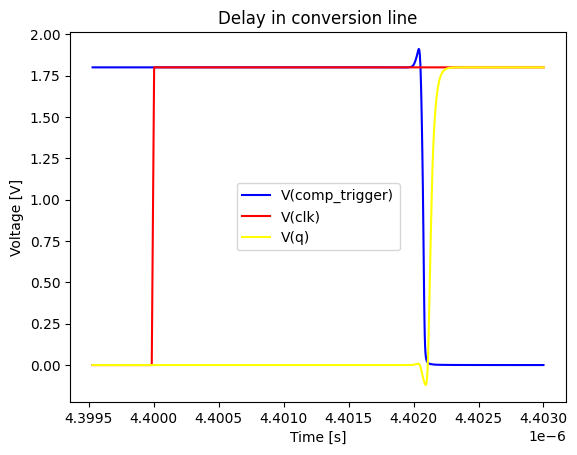

In [ ]:
#@title Comparator simulation
!cp sscs-chipathon-sar-adc/spice/.spiceinit .
!ngspice -b sscs-chipathon-sar-adc/spice/comp.spice &> /dev/null
from pandas.io.parsers.readers import validate_header_arg
import math
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

df = pd.read_csv("delay.txt", delim_whitespace=True, header=None)

df.columns = ["Time [us]", "V(clk)", "V(comp_trigger)", "V(q)"]
ax.set_title("Delay in conversion line")
ax.set_ylabel("Voltage [V]")
ax.set_xlabel("Time [s]")
ax.plot(df["Time [us]"], df["V(comp_trigger)"], color = 'blue')
ax.plot(df["Time [us]"], df["V(clk)"], color = 'red')
ax.plot(df["Time [us]"], df["V(q)"], color = 'yellow')
#ax.set_xlim(4.4,4.401)

plt.legend(["V(comp_trigger)","V(clk)","V(q)"])
plt.show()

<div align="center">
Figure 4: Delay in comparator operation in [8].
</div>

The design in [8], which includes both the pre-amp and the strongarm comparator implemented in the SKY130 technology, has been simulated (offline, not included to this notebook for now). Figure 4 shows the delay in the conversion operation, which can be critical for the system-level operation. The response of the full comparator is mainly limited by the latch response. From the plot, the delay in the conversion line can be estimated to be around 1 ns. This gives us preliminary information about the maximum frequency at which the comparator can operate. The detailed analysis needs to be done during the study phase of the project.


### SAR Logic

The SAR logic (shown in Figure 5) consists of a series of D-type flip-flops that control the switches in the DAC to gradually approach the input voltage and generate a digital representation of this voltage [10]. The SAR logic takes as input the comparator output, a clock signal (which we need to determine if its going to be generated internally or if it comes from the rest of the system), and a reset signal that also initiates the conversion process. Upon completition of the series of comparisons, and end-of-conversion (EOC) signal is produced as output.

We implemented a description of the SAR logic using the Verilog HDL. Our goal is to use this implementation in the creation of the final design, either by directly instantiating the GF180MCU standard logic cells (primarily D-type flip-flops) or by using it as a reference for a custom, manually placed analog design.

<img src="https://git.1159.cl/Mario1159/sscs-chipathon-sar-adc/raw/branch/main/figures/sar-logic.svg" align="left" width="100%"/>


<div align="center">
Figure 5: Schematic of the SAR logic for an 8-bit ADC.
</div>

Figure 6 shows an HDL simulation of the SAR logic generated using Icarus Verilog. The simulations show the waveforms for the digital output for an given input signal. These simulations omit the external sampling clock, which would enable the internal SAR clock that propagates the data through the flip-flops performing the analog-to-digital conversion. When all the bits are checked (after 12 cycle), there will be a data ready clock that will send the generated 12 Bits out of the ADC with the help of D flip-flops.

VCD info: dumpfile Code_Reg_Out.txt opened for output.
/content/sscs-chipathon-sar-adc/verilog/tb/SAR_SIM.sv:65: $finish called at 102 (1s)


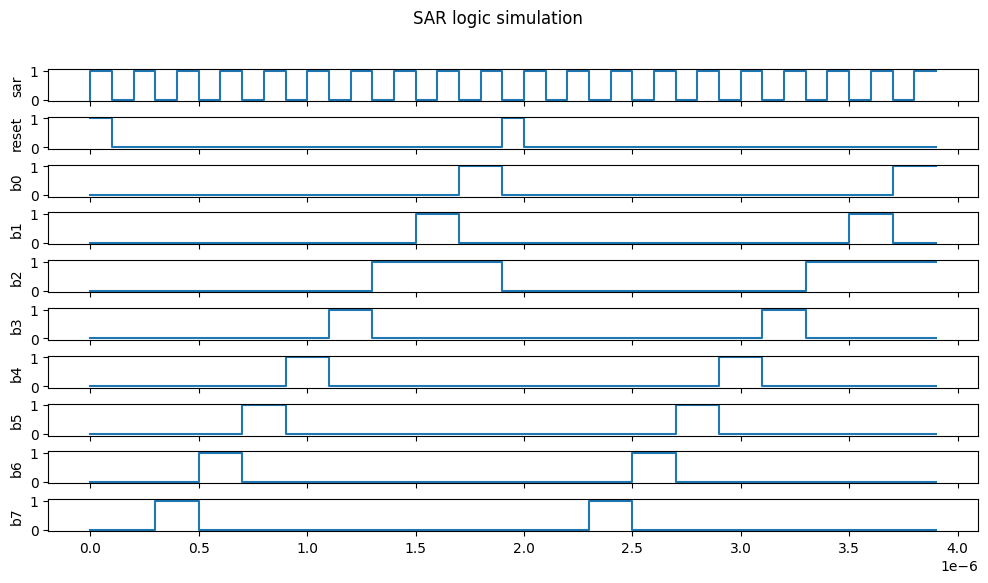

In [ ]:
#@title SAR Simulation
# ICARUS
!iverilog -Wall -o /content/sscs-chipathon-sar-adc/data/sar/Code_register /content/sscs-chipathon-sar-adc/verilog/rtl/Code_Register.v /content/sscs-chipathon-sar-adc/verilog/rtl/Sequencer_Register.v /content/sscs-chipathon-sar-adc/verilog/tb/SAR_SIM.sv
!vvp  /content/sscs-chipathon-sar-adc/data/sar/Code_register 

#SIM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('output.csv', header=0)
clk_sar = df['clk_sar'].to_numpy()
reset = df['reset'].to_numpy()
Vdac_b0 = df['Vdac_b0'].to_numpy()
Vdac_b0[0] = Vdac_b0[1]
Vdac_b1 = df['Vdac_b1'].to_numpy()
Vdac_b1[0] = Vdac_b0[1]
Vdac_b2 = df['Vdac_b2'].to_numpy()
Vdac_b2[0] = Vdac_b0[1]
Vdac_b3 = df['Vdac_b3'].to_numpy()
Vdac_b3[0] = Vdac_b0[1]
Vdac_b4 = df['Vdac_b4'].to_numpy()
Vdac_b4[0] = Vdac_b0[1]
Vdac_b5 = df['Vdac_b5'].to_numpy()
Vdac_b5[0] = Vdac_b0[1]
Vdac_b6 = df['Vdac_b6'].to_numpy()
Vdac_b6[0] = Vdac_b0[1]
Vdac_b7 = df['Vdac_b7'].to_numpy()
Vdac_b7[0] = Vdac_b0[1]

Ts = 1e-7
time = np.arange(0, len(clk_sar) * Ts, Ts)

##########
N = 40
time = time[:N]
clk_sar = clk_sar[:N]
reset = reset[:N]
Vdac_b0 = Vdac_b0[:N]
Vdac_b1 = Vdac_b1[:N]
Vdac_b2 = Vdac_b2[:N]
Vdac_b3 = Vdac_b3[:N]
Vdac_b4 = Vdac_b4[:N]
Vdac_b5 = Vdac_b5[:N]
Vdac_b6 = Vdac_b6[:N]
Vdac_b7 = Vdac_b7[:N]
##########

# Creating the subplots
fig, ax = plt.subplots(nrows=10, ncols=1, sharex=True, sharey=False, figsize=(12, 6))

ax[0].step(time, clk_sar)
ax[1].step(time, reset)
ax[2].step(time, Vdac_b0)
ax[3].step(time, Vdac_b1)
ax[4].step(time, Vdac_b2)
ax[5].step(time, Vdac_b3)
ax[6].step(time, Vdac_b4)
ax[7].step(time, Vdac_b5)
ax[8].step(time, Vdac_b6)
ax[9].step(time, Vdac_b7 )

ax[0].set_ylabel('sar')
ax[1].set_ylabel('reset')
ax[2].set_ylabel('b0')
ax[3].set_ylabel('b1')
ax[4].set_ylabel('b2')
ax[5].set_ylabel('b3')
ax[6].set_ylabel('b4')
ax[7].set_ylabel('b5')
ax[8].set_ylabel('b6')
ax[9].set_ylabel('b7')

fig.subplots_adjust(hspace=0.5)
fig.suptitle('SAR logic simulation')
plt.show()

<div align="center">
Figure 6: SAR logic Icarus Verilog simulation.
</div>

### CDAC

Each CDAC uses a capacitive fully-differential structure to achieve low noise. Firstly, a monotonic switch DAC architecture was discussed to be used. However, to reduce the capacitor total area, the structure of each converter will be dictated by a split-array DAC architecture [11].  In this configuration, a capacitor between the LSB and MSB regions is placed as an attenuator, bridging the capacitor sizes of the MSB bits. The unit capacitance $C_u$ in the schematic is the lowest capacitance that can be achieved in this technology, this correspond to $37.5fF$ using $\leq 6 V$ [MIM capacitors](https://gf180mcu-pdk.readthedocs.io/en/latest/analog/spice/elec_specs/elec_specs_6_4.html) provided by the PDK. In general, MOM capacitors are known to have a better matching performance. However, currently the GF180 PDK does not provide information about this primitive, thus the use of MOM capacitor should be further investigated at the layout stage.

The actual values of the capacitances may not be the desired ones due to parasitic capacitances, fabrication tolerances, or other factors that affect the transient response of the DAC. Therefore, it is necessary to have a calibration system [12], such as small capacitances which can be added to tune the full system chain ENOB. In our example shown in Figure 7 for a 12-bit CDAC, the split capacitor needs to have a factor 64/63 times the unit capacitance $C_u$, which may be challenging to achieve. Therefore, a good target for our calibration efforts would focus on this capacitor.

The schematic for this design can be viewed at figure 7 using a top plate arrangement, this is the design that will be simulated in the next section. 
From our reseach the top plate design is not commonly used, since the main advantage of this is reduced total area, a  slight reduced power consumption and simplicity with the disadvantages of increased non linearity, thus sacrificig precision. Since the main power consumption of a SAR ADC comes from the comparator, decreasign the precision at the expense of a minor power consumption is not ideal. This will be further studied in pair with adding an intermediate voltage state $(V_{ref}/2)$ that would improve the output detail.

<img src="https://git.1159.cl/Mario1159/sscs-chipathon-sar-adc/raw/branch/main/figures/cdac.svg" width=1020/>
<div align="center">Figure 7: 12-bit Top plate CDAC</div>

#### CDAC Simulation

A simulation of this schematic is provided using a pull-down NMOS and pull-up PMOS design for each switch. In this simulation the 12-bit bus input $D$ will be set as an arbitrary transient signal, expecting its analog signal in the output.

$D$ will change its value exponentially (switching a binary digit $D_i$ each sample step). This signal can be seen encoded in base-10 in Figure 8 (left).

The output $V_{out}$ should represent the decoded D value as precisely as possible. In the output plot in Figure 8 (right) we can see that this digital-analog mapping is achieved in a proper way using the GF180 transistors and MIM capacitors available in the technology (which may be replaced by a MOM implementation in further iterations, as explained above). The simulation can be customized to vary the signal timescale, stoptime and capacitance, so that the dynamic performance of the system can be studied.

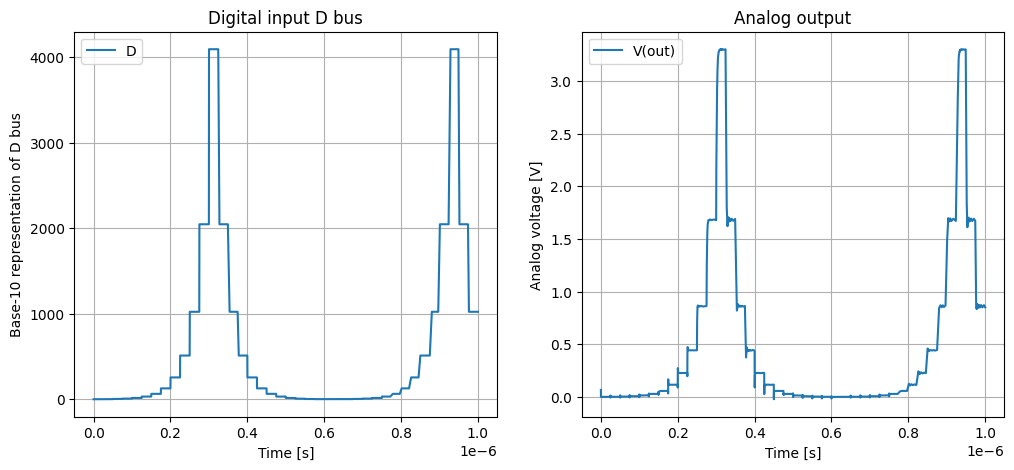

In [ ]:
#@title Plot CDAC Simulation
#@markdown Parameters can be adjusted interactively through forms supported in Google Collab 

#@markdown ---
#@markdown Signal timescale factor
signal_timescale = 25 #@param {type:"slider", min:0, max:1000, step:0.1}
#@markdown ---
#@markdown Simulation stop time in nanoseconds
stoptime = 1000 #@param {type:"slider", min:0, max:1000, step:0.1}
#@markdown ---
#@markdown Width of the square capacitor in micrometers (5um=37.5fF)
c_width = 5 #@param {type:"slider", min:5, max:15, step:0.1}
with open('param.spice', 'wt') as file:
    file.write(f'.param timescale={signal_timescale}n\n')
    file.write(f'.param stoptime={stoptime}n\n')
    file.write(f'.param cu={c_width}u\n')
!ngspice -b sscs-chipathon-sar-adc/spice/cdac.spice &> /dev/null
from pandas.io.parsers.readers import validate_header_arg
import math
import pandas as pd
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 5, forward=True)
df = pd.read_csv("output.txt", delim_whitespace=True, header=None)
df.columns = ["Time [s]", "V(out)", "V(d1)", "V(d2)", "V(d3)", "V(d4)", "V(d5)" ,"V(d6)", "V(d7)", "V(d8)", "V(d9)", "V(d10)", "V(d11)" ,"V(d12)"]
vh = 3.3
df["D"] =  df["V(d1)"].apply(lambda x:  (x/vh)*1)   + df["V(d2)"].apply(lambda x:  (x/vh)*2)     + df["V(d3)"].apply(lambda x:  (x/vh)*4) 
df["D"] += df["V(d4)"].apply(lambda x:  (x/vh)*8)   + df["V(d5)"].apply(lambda x:  (x/vh)*16)    + df["V(d6)"].apply(lambda x:  (x/vh)*32)
df["D"] += df["V(d7)"].apply(lambda x:  (x/vh)*64)  + df["V(d8)"].apply(lambda x:  (x/vh)*128)   + df["V(d9)"].apply(lambda x:  (x/vh)*256)
df["D"] += df["V(d10)"].apply(lambda x: (x/vh)*512) + df["V(d11)"].apply(lambda x: (x/vh)*1024)  + df["V(d12)"].apply(lambda x: (x/vh)*2048)
axes[0].set_title("Digital input D bus")
axes[0].set_ylabel("Base-10 representation of D bus")
df.plot(x="Time [s]", y="D", grid=True, ax=axes[0])
axes[1].set_title("Analog output")
axes[1].set_ylabel("Analog voltage [V]")
df.plot(x="Time [s]", y="V(out)", grid=True, ax=axes[1])
plt.show()

<div align="center">
Figure 8: (left) Digital input to the CDAC implemented and simulated in GF180 technology, and (right) analog simulated output. 
</div>

## III. Summary of your Idea

The main objective is to implement a full SAR ADC design from specifications to GDS/Tapeout, exploring the capabilities of the GF180 technology to achieve 9 ENOB with minimum area/power resources and MS/s-level speed. The target application is the oscilloscope data conversion channel for a lab-bench-on-chip ASIC. The architecture and the initial building blocks will be based on the description above, but further reserch on the specific aspects of this technology may motivate other topology choices, following the study phase and a more extensive research on the requirements and specs. We hope that the proposed 12 bit SAR ADC will be a reliable IP that will contribute to the open source ecosystem.

A secondary objective of our project is to focus on analog mixed-signal IC design automation starting on early design stages. Being layout one of the most challenging aspects of this design, an initial target is to build scripted layout generators for the most relevant building blocks of the system, starting with the CDAC and the comparator. Later, aspects such as technology portability (e.g. between the SKY130 and the GF180 technologies) can be considered, if time allows.

## IV. Planification and Tasks

Team members are divided in subgroups dedicated to each module of the ADC, the next steps for each group would be focused in consolidating the simulations to caracterize each part of the system and put it to the max capacity. Then each group will draw the layouts of each block.



<img src="https://git.1159.cl/Mario1159/sscs-chipathon-sar-adc/raw/branch/main/figures/planification.png"/>

## V. References

[1] Hurrell, C. P., Lyden, C., Laing, D., Hummerston, D., & Vickery, M. (2010). An 18 b 12.5 MS/s ADC With 93 dB SNR. IEEE Journal of Solid-State Circuits, 45(12), 2647–2654. https://doi.org/10.1109/JSSC.2010.2075310

[2] Global Foundries & Google. (2020). GlobalFoundries GF180MCU PDK. https://gf180mcu-pdk.readthedocs.io/en/latest/

[3] Harpe, P. (2022). Low-Power SAR ADCs: Basic Techniques and Trends. IEEE Open Journal of the Solid-State Circuits Society, 2, 73–81. https://doi.org/10.1109/OJSSCS.2022.3211482

[4] Razavi, B. (2015). The bootstrapped switch [a circuit for all seasons]. IEEE Solid-State Circuits Magazine, 7(3), 12-15.

[5] Yuan, F. (2021, August). Bootstrapping techniques for energy-efficient SAR ADCs: A state-of-the-art review. In 2021 IEEE International Midwest Symposium on Circuits and Systems (MWSCAS) (pp. 575-578). IEEE.

[6] Wang, L., Ren, J., Yin, W., Chen, T., & Xu, J. (2007, May). A high-speed high-resolution low-distortion CMOS bootstrapped switch. In 2007 IEEE International Symposium on Circuits and Systems (pp. 1721-1724). IEEE.

[7] Zhuang, H., Cao, Q., Peng, X., & Tang, H. (2021). A Bootstrapped Switch with Accelerated Rising Speed and Reduced On-Resistance. 2021 IEEE International Symposium on Circuits and Systems (ISCAS), 1–5. https://doi.org/10.1109/ISCAS51556.2021.9401785

[8] Moser, M. (2023). Design of a 1.2MS/s Charge-Redistribution Non-Binary SAR-ADC utilizing the SKY130 Open-Source Technology. https://github.com/w32agobot/SKY130_SAR-ADC

[9] Sheikhaei, S., Mirabbasi, S., & Ivanov, A. (2005, May). A 0.35/spl mu/m CMOS comparator circuit for high-speed ADC applications. In 2005 IEEE International Symposium on Circuits and Systems (pp. 6134-6137). IEEE.

[10] Aldacher, M. (2021). Design of a Low-Power Asynchronous SAR ADC in 45 nm CMOS Technology. San Jose State University.

[11] Zhao, H. (2017). Implementation of High Speed SAR ADC with Proposed Efficient DAC Architecture. Auburn University.

[12] Chen, Y., Zhu, X., Tamura, H., Kibune, M., Tomita, Y., Hamada, T., ... & Kuroda, T. (2010). Split capacitor DAC mismatch calibration in successive approximation ADC. IEICE transactions on electronics, 93(3), 295-302.






---





[x] D. Osipov and S. Paul, "Flying-Capacitor Bottom-Plate Sampling Scheme for Low-Power High-Resolution SAR ADCs," 2018 IEEE Nordic Circuits and Systems Conference (NORCAS): NORCHIP and International Symposium of System-on-Chip (SoC), Tallinn, Estonia, 2018, pp. 1-4, https://doi.org/10.1109/NORCHIP.2018.8573458

[x] Kardonik, O. (2013). A Study of SAR ADC and Implementation of 10-bit Asynchronous Design. The University of Texas at Austin.
